In [1]:
import argparse
import csv
from datetime import datetime
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

THRESHOLD = 0.6
NUM_ITERS = 1000

BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)


In [2]:
def drawInliersOutliers(image, point_map, inliers):
    rows, cols = image.shape
    retImage = np.zeros((rows, cols, 3), dtype='uint8')
    retImage[:, :, :] = np.dstack([image] * 3)

    for x1, y1, x2, y2 in point_map:
        point = (int(x1), int(y1))
        color = GREEN if (x1, y1, x2, y2) in inliers else RED
        cv2.circle(retImage, point, 4, color, 1)

    return retImage

def drawMatches(image1, image2, point_map, inliers=None, max_points=1000):
    rows1, cols1 = image1.shape
    rows2, cols2 = image2.shape

    matchImage = np.zeros((max(rows1, rows2), cols1 + cols2, 3), dtype='uint8')
    matchImage[:rows1, :cols1, :] = np.dstack([image1] * 3)
    matchImage[:rows2, cols1:cols1 + cols2, :] = np.dstack([image2] * 3)

    small_point_map = [point_map[i] for i in np.random.choice(len(point_map), max_points)]

    for x1, y1, x2, y2 in small_point_map:
        point1 = (int(x1), int(y1))
        point2 = (int(x2 + image1.shape[1]), int(y2))
        color = BLUE if inliers is None else (GREEN if (x1, y1, x2, y2) in inliers else RED)
        cv2.line(matchImage, point1, point2, color, 1)

    for x1, y1, x2, y2 in small_point_map:
        point1 = (int(x1), int(y1))
        point2 = (int(x2 + image1.shape[1]), int(y2))
        cv2.circle(matchImage, point1, 5, BLUE, 1)
        cv2.circle(matchImage, point2, 5, BLUE, 1)

    return matchImage

def computeHomography(pairs):
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    A = np.array(A)

    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1 / H.item(8)) * H
    return H

def dist(pair, H):
    p1 = np.array([pair[0], pair[1], 1])
    p2 = np.array([pair[2], pair[3], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate

    return np.linalg.norm(np.transpose(p2) - p2_estimate)

def RANSAC(point_map, threshold=THRESHOLD, verbose=True):
    if verbose:
        print(f'Running RANSAC with {len(point_map)} points...')
    bestInliers = set()
    homography = None
    for i in range(NUM_ITERS):
        pairs = [point_map[i] for i in np.random.choice(len(point_map), 4)]
        H = computeHomography(pairs)
        inliers = {(c[0], c[1], c[2], c[3]) for c in point_map if dist(c, H) < 500}

        if verbose:
            print(f'\x1b[2K\r└──> iteration {i + 1}/{NUM_ITERS} ' +
                  f'\t{len(inliers)} inlier' + ('s ' if len(inliers) != 1 else ' ') +
                  f'\tbest: {len(bestInliers)}', end='')

        if len(inliers) > len(bestInliers):
            bestInliers = inliers
            homography = H
            if len(bestInliers) > (len(point_map) * threshold):
                break

    if verbose:
        print(f'\nNum matches: {len(point_map)}')
        print(f'Num inliers: {len(bestInliers)}')
        print(f'Min inliers: {len(point_map) * threshold}')

    return homography, bestInliers

def createPointMap(image1, image2, verbose=True):
    if verbose:
        print('Finding keypoints and descriptors for both images...')
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    matches = cv2.BFMatcher(cv2.NORM_L2, True).match(desc1, desc2)

    point_map = np.array([
        [kp1[match.queryIdx].pt[0], kp1[match.queryIdx].pt[1],
         kp2[match.trainIdx].pt[0], kp2[match.trainIdx].pt[1]] for match in matches
    ])

    return point_map


In [3]:
def main(image1, image2, verbose=True):
    if verbose:
        print('Creating point map...')
    point_map = createPointMap(image1, image2, verbose=verbose)

    homography, inliers = RANSAC(point_map, verbose=verbose)

    cv2.imwrite('inlier_matches.png', drawMatches(image1, image2, point_map, inliers))

    with open('info.txt', 'w') as f:
        f.write(f'Homography:\n{str(homography)}\n\n')
        f.write(f'Num inliers: {len(inliers)}')

    return point_map, inliers, homography


Creating point map...
Finding keypoints and descriptors for both images...
Running RANSAC with 311 points...
└──> iteration 1000/1000 	69 inliers 	best: 146[2KK[2K
Num matches: 311
Num inliers: 146
Min inliers: 186.6
Homography matrix:
 [[-4.34951563e-01 -1.60436804e-01  4.80007966e+02]
 [-3.62154953e-01 -1.37163335e-01  4.05572397e+02]
 [-9.05120185e-04 -3.34280269e-04  1.00000000e+00]]


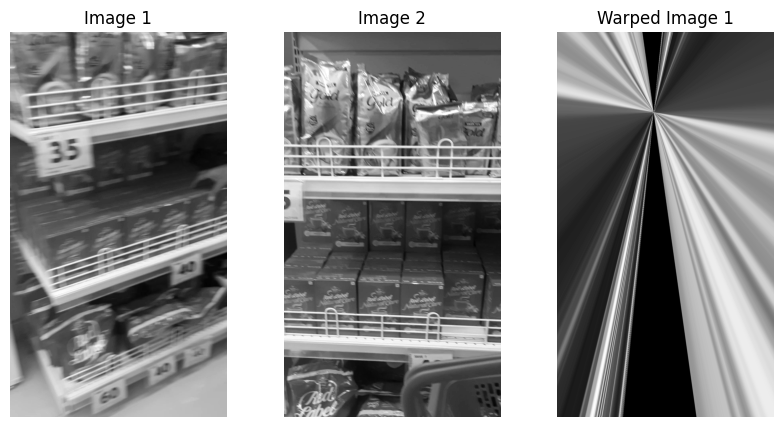

In [4]:
INPUT_PATH = r'C:\Users\Anuj Bohra\Desktop\IIT_Patna\warp\input'

image1_path = os.path.join(INPUT_PATH, '452_train.jpg')
image2_path = os.path.join(INPUT_PATH, '464_train.jpg')

image1 = cv2.imread(image1_path, 0)
image2 = cv2.imread(image2_path, 0)

if image1 is None or image2 is None:
    print("Error: One or both images are not loaded correctly.")
else:
    point_map, inliers, homography = main(image1, image2)
    print("Homography matrix:\n", homography)

    im_dst = cv2.warpPerspective(image1, homography, (image1.shape[1], image1.shape[0]))

    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.imshow(image1, cmap='gray'), plt.title('Image 1'), plt.axis('off')
    plt.subplot(132), plt.imshow(image2, cmap='gray'), plt.title('Image 2'), plt.axis('off')
    plt.subplot(133), plt.imshow(im_dst, cmap='gray'), plt.title('Warped Image 1'), plt.axis('off')
    plt.show()
